<a href="https://colab.research.google.com/github/AnanyaTyagi/Analysis-of-crime-data-using-machine-learning/blob/master/Graph_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Drive mounted
Device: cuda
Checkpoint directory: /content/drive/MyDrive/diffusion_cifar10_runs
Graphs will be saved to: /content/drive/MyDrive/model_evaluation_graphs
✅ Checkpoint directory found

EVALUATING DIFFUSION MODEL CHECKPOINTS
Will evaluate epochs: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
Found 304 checkpoints
Evaluating 10 selected checkpoints: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

Evaluating Epoch 50

Generating samples from: diffusion_epoch_050.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_50
✅ Epoch 50: FID=349.36, IS=3.08±0.09

Evaluating Epoch 100

Generating samples from: diffusion_epoch_100.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_100
✅ Epoch 100: FID=389.95, IS=2.83±0.13

Evaluating Epoch 150

Generating samples from: diffusion_epoch_150.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_150
✅ Epoch 150: FID=257.79, IS=3.99±0.22

Evaluating Epoch 200

Generating samples from: diffusion_epoch_200.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_200
✅ Epoch 200: FID=166.62, IS=5.41±0.23

Evaluating Epoch 250

Generating samples from: diffusion_epoch_250.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_250
✅ Epoch 250: FID=91.00, IS=6.93±0.44

Evaluating Epoch 300

Generating samples from: diffusion_epoch_300.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_300
✅ Epoch 300: FID=53.12, IS=7.83±0.32

Evaluating Epoch 350

Generating samples from: diffusion_epoch_350.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_350
✅ Epoch 350: FID=26.36, IS=8.20±0.28

Evaluating Epoch 400

Generating samples from: diffusion_epoch_400.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_400
✅ Epoch 400: FID=16.03, IS=8.37±0.24

Evaluating Epoch 450

Generating samples from: diffusion_epoch_450.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_450
✅ Epoch 450: FID=14.22, IS=8.38±0.52

Evaluating Epoch 500

Generating samples from: diffusion_epoch_500.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples/diffusion/epoch_500
✅ Epoch 500: FID=13.48, IS=8.31±0.32

✅ Graph saved to: /content/drive/MyDrive/model_evaluation_graphs/diffusion_metrics_vs_epochs.png


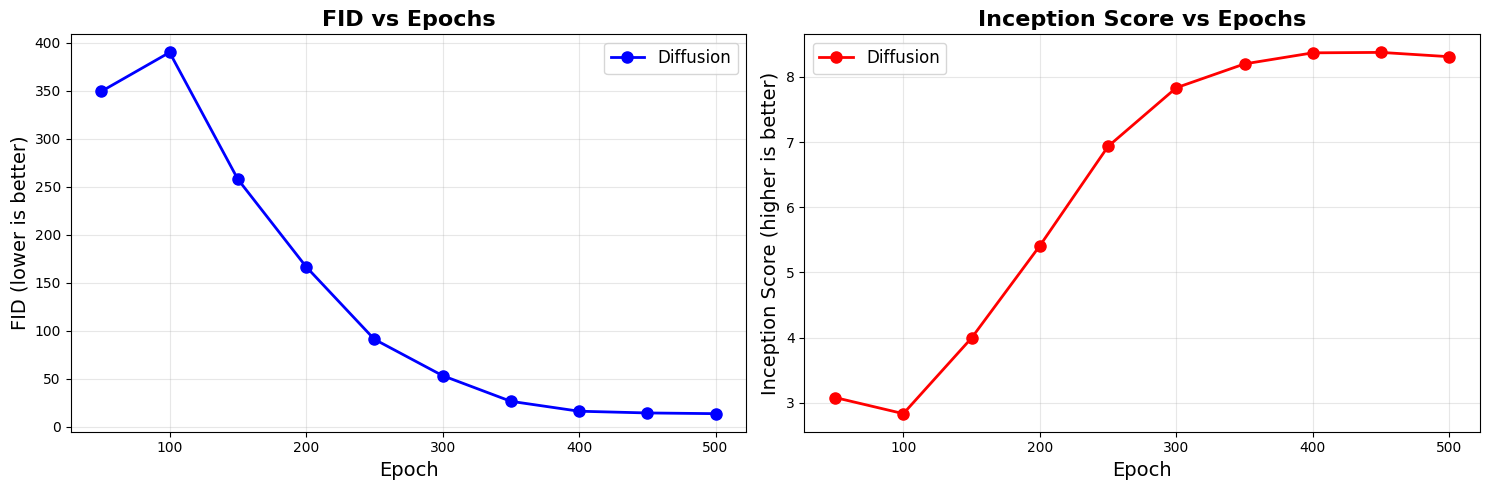

✅ Data saved to: /content/drive/MyDrive/model_evaluation_graphs/diffusion_metrics.csv

SUMMARY
Best FID: 13.48 at epoch 500
Best IS: 8.38 at epoch 450
Final FID: 13.48 at epoch 500
Final IS: 8.31 at epoch 500

✅ Evaluation complete!


In [ ]:
# ============================================================
# EVALUATE ALL CHECKPOINTS AND PLOT FID/IS vs EPOCHS (FIXED)
# ============================================================

import os
import glob
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torchvision.utils import save_image
import math

# Try to mount drive, but continue if it fails
try:
    from google.colab import drive
    if not os.path.exists('/content/drive/MyDrive'):
        drive.mount('/content/drive')
    print("✅ Drive mounted")
except Exception as e:
    print(f"⚠️ Drive mount failed or not in Colab: {e}")
    print("Make sure to update the paths below to your actual checkpoint locations")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------------------------
# PATHS - UPDATE THESE TO YOUR ACTUAL DIRECTORIES
# -------------------------

# For Diffusion
DIFFUSION_DIR = "/content/drive/MyDrive/diffusion_cifar10_runs"
DIFFUSION_CKPT_PATTERN = "diffusion_epoch_*.pth"

# Output directory for graphs
GRAPH_OUTPUT_DIR = "/content/drive/MyDrive/model_evaluation_graphs"
os.makedirs(GRAPH_OUTPUT_DIR, exist_ok=True)

print(f"Checkpoint directory: {DIFFUSION_DIR}")
print(f"Graphs will be saved to: {GRAPH_OUTPUT_DIR}")

# Verify directory exists
if not os.path.exists(DIFFUSION_DIR):
    print(f"❌ ERROR: Directory does not exist: {DIFFUSION_DIR}")
    print("Please update DIFFUSION_DIR to the correct path")
else:
    print(f"✅ Checkpoint directory found")


# -------------------------
# MODEL DEFINITIONS (same as training)
# -------------------------

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device_ = t.device
        half = self.dim // 2
        emb_factor = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device_) * -emb_factor)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

def get_num_groups(channels):
    if channels >= 32:
        num_groups = 8
    elif channels >= 16:
        num_groups = 4
    elif channels >= 8:
        num_groups = 2
    else:
        num_groups = 1
    while channels % num_groups != 0:
        num_groups -= 1
    return max(1, num_groups)

class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        while channels % num_heads != 0 and num_heads > 1:
            num_heads -= 1
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(get_num_groups(channels), channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.chunk(3, dim=1)
        q = q.view(B, self.num_heads, C // self.num_heads, H * W)
        k = k.view(B, self.num_heads, C // self.num_heads, H * W)
        v = v.view(B, self.num_heads, C // self.num_heads, H * W)
        scale = (C // self.num_heads) ** -0.5
        attn = torch.softmax(torch.einsum('bhcn,bhcm->bhnm', q, k) * scale, dim=-1)
        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, H, W)
        return x + self.proj(out)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        self.block1 = nn.Sequential(
            nn.GroupNorm(get_num_groups(in_ch), in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(get_num_groups(out_ch), out_ch),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        t = self.time_mlp(t_emb)[:, :, None, None]
        h = h + t
        h = self.block2(h)
        return h + self.res_conv(x)

class UNet(nn.Module):
    def __init__(self, img_ch=3, base_channels=128, time_dim=256, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        ch1 = base_channels
        ch2 = base_channels * 2
        ch3 = base_channels * 4

        self.down1 = nn.ModuleList([ResBlock(img_ch, ch1, time_dim, dropout), ResBlock(ch1, ch1, time_dim, dropout)])
        self.down2 = nn.ModuleList([ResBlock(ch1, ch2, time_dim, dropout), ResBlock(ch2, ch2, time_dim, dropout)])
        self.attn2 = SelfAttention(ch2, num_heads=4)
        self.down3 = nn.ModuleList([ResBlock(ch2, ch3, time_dim, dropout), ResBlock(ch3, ch3, time_dim, dropout)])
        self.attn3 = SelfAttention(ch3, num_heads=4)
        self.pool = nn.AvgPool2d(2)

        self.mid1 = ResBlock(ch3, ch3, time_dim, dropout)
        self.mid_attn = SelfAttention(ch3, num_heads=4)
        self.mid2 = ResBlock(ch3, ch3, time_dim, dropout)

        self.up2 = nn.ModuleList([ResBlock(ch3 + ch2, ch2, time_dim, dropout), ResBlock(ch2, ch2, time_dim, dropout)])
        self.attn_up2 = SelfAttention(ch2, num_heads=4)
        self.up1 = nn.ModuleList([ResBlock(ch2 + ch1, ch1, time_dim, dropout), ResBlock(ch1, ch1, time_dim, dropout)])
        self.attn_up1 = SelfAttention(ch1, num_heads=4)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

        self.final = nn.Sequential(
            nn.GroupNorm(get_num_groups(ch1), ch1),
            nn.SiLU(),
            nn.Conv2d(ch1, img_ch, 3, padding=1),
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h = x
        for block in self.down1:
            h = block(h, t_emb)
        d1 = h
        h = self.pool(h)
        for block in self.down2:
            h = block(h, t_emb)
        h = self.attn2(h)
        d2 = h
        h = self.pool(h)
        for block in self.down3:
            h = block(h, t_emb)
        h = self.attn3(h)
        h = self.mid1(h, t_emb)
        h = self.mid_attn(h)
        h = self.mid2(h, t_emb)
        h = self.upsample(h)
        h = torch.cat([h, d2], dim=1)
        for block in self.up2:
            h = block(h, t_emb)
        h = self.attn_up2(h)
        h = self.upsample(h)
        h = torch.cat([h, d1], dim=1)
        for block in self.up1:
            h = block(h, t_emb)
        h = self.attn_up1(h)
        return self.final(h)


# -------------------------
# DIFFUSION SAMPLING
# -------------------------

T = 1000

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

betas = cosine_beta_schedule(T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], dtype=torch.float32), alphas_cumprod[:-1]], dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

betas = betas.to(device)
alphas = alphas.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)
posterior_variance = posterior_variance.to(device)

def denorm(x):
    return (x.clamp(-1,1) + 1)/2

def p_sample(model, x, t_index: int):
    b = x.size(0)
    t = torch.full((b,), t_index, device=device, dtype=torch.long)
    eps_theta = model(x, t)
    beta_t = betas[t_index]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t_index]
    sqrt_recip_alpha_t = sqrt_recip_alphas[t_index]
    model_mean = sqrt_recip_alpha_t * (x - beta_t / sqrt_one_minus_alpha_bar_t * eps_theta)
    if t_index == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        var = posterior_variance[t_index]
        return model_mean + torch.sqrt(var) * noise

@torch.no_grad()
def p_sample_loop(model, shape):
    model.eval()
    img = torch.randn(shape, device=device)
    for t_index in reversed(range(T)):
        img = p_sample(model, img, t_index)
    return img


# -------------------------
# EVALUATION FUNCTIONS
# -------------------------

def load_model_from_checkpoint(ckpt_path):
    """Load model from checkpoint with proper EMA handling"""

    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    # Create model
    model = UNet(img_ch=3, base_channels=128, time_dim=256, dropout=0.1).to(device)

    # Try to get the right state dict
    if 'ema' in ckpt:
        state_dict = ckpt['ema']
    elif 'model' in ckpt:
        state_dict = ckpt['model']
    else:
        state_dict = ckpt

    # Load with strict=False to handle any mismatches
    try:
        model.load_state_dict(state_dict, strict=True)
    except Exception as e:
        print(f"Warning: Loading with strict=False due to: {e}")
        model.load_state_dict(state_dict, strict=False)

    return model


def generate_samples_from_checkpoint(ckpt_path, output_dir, num_samples=5000):
    """Generate samples from a checkpoint and save to directory"""
    print(f"\nGenerating samples from: {os.path.basename(ckpt_path)}")

    model = load_model_from_checkpoint(ckpt_path)
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    bs = 100
    saved = 0

    with torch.no_grad():
        pbar = tqdm(total=num_samples, desc="Generating")
        while saved < num_samples:
            cur = min(bs, num_samples - saved)
            samples = p_sample_loop(model, (cur, 3, 32, 32))
            samples = denorm(samples).cpu()

            for i in range(cur):
                save_image(samples[i], os.path.join(output_dir, f"{saved + i:05d}.png"))

            saved += cur
            pbar.update(cur)
        pbar.close()

    del model
    torch.cuda.empty_cache()

    return output_dir


def calculate_metrics_for_samples(samples_dir):
    """Calculate FID and IS for generated samples"""
    print(f"Calculating metrics for: {samples_dir}")

    try:
        from torch_fidelity import calculate_metrics
    except:
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'torch-fidelity>=0.3.0'])
        from torch_fidelity import calculate_metrics

    orig_torch_load = torch.load
    def _compat_load(*args, **kwargs):
        kwargs.setdefault("weights_only", False)
        return orig_torch_load(*args, **kwargs)
    torch.load = _compat_load

    try:
        metrics_fid = calculate_metrics(
            input1=samples_dir,
            input2="cifar10-train",
            fid=True,
            kid=False,
            isc=False,
            cuda=(device == "cuda"),
            verbose=False,
        )

        metrics_is = calculate_metrics(
            input1=samples_dir,
            fid=False,
            kid=False,
            isc=True,
            cuda=(device == "cuda"),
            verbose=False,
        )
    finally:
        torch.load = orig_torch_load

    fid = metrics_fid.get("frechet_inception_distance", None)
    is_mean = (metrics_is.get("inception_score_mean") or
               metrics_is.get("isc_mean") or
               metrics_is.get("inception_score"))
    is_std = metrics_is.get("inception_score_std", metrics_is.get("isc_std", None))

    return fid, is_mean, is_std


def evaluate_all_checkpoints(model_dir, ckpt_pattern, temp_sample_dir, num_samples=5000,
                             select_epochs=None):
    """Evaluate all checkpoints in a directory"""

    ckpt_files = sorted(glob.glob(os.path.join(model_dir, ckpt_pattern)))

    if not ckpt_files:
        print(f"❌ No checkpoints found matching pattern: {ckpt_pattern} in {model_dir}")
        return None, None, None

    print(f"Found {len(ckpt_files)} checkpoints")

    epochs = []
    for f in ckpt_files:
        match = re.search(r'epoch[_-](\d+)', os.path.basename(f))
        if match:
            epochs.append(int(match.group(1)))

    if not epochs:
        print("❌ Could not extract epoch numbers from checkpoint filenames")
        return None, None, None

    sorted_pairs = sorted(zip(epochs, ckpt_files))
    epochs, ckpt_files = zip(*sorted_pairs)

    if select_epochs is not None:
        filtered_pairs = [(e, f) for e, f in zip(epochs, ckpt_files) if e in select_epochs]
        if filtered_pairs:
            epochs, ckpt_files = zip(*filtered_pairs)
            print(f"Evaluating {len(epochs)} selected checkpoints: {list(epochs)}")
        else:
            print(f"❌ No checkpoints found for selected epochs: {select_epochs}")
            return None, None, None

    fids = []
    is_means = []
    is_stds = []

    for epoch, ckpt_path in zip(epochs, ckpt_files):
        print(f"\n{'='*60}")
        print(f"Evaluating Epoch {epoch}")
        print(f"{'='*60}")

        try:
            sample_output_dir = os.path.join(temp_sample_dir, f"epoch_{epoch}")
            generate_samples_from_checkpoint(ckpt_path, sample_output_dir, num_samples)

            fid, is_mean, is_std = calculate_metrics_for_samples(sample_output_dir)

            fids.append(fid)
            is_means.append(is_mean)
            is_stds.append(is_std if is_std is not None else 0)

            # FIXED: Properly format the is_std value
            is_std_str = f"{is_std:.2f}" if is_std else "0.00"
            print(f"✅ Epoch {epoch}: FID={fid:.2f}, IS={is_mean:.2f}±{is_std_str}")

            import shutil
            shutil.rmtree(sample_output_dir)

        except Exception as e:
            print(f"❌ Error evaluating epoch {epoch}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return list(epochs), fids, is_means


# -------------------------
# MAIN EVALUATION
# -------------------------

print("\n" + "="*70)
print("EVALUATING DIFFUSION MODEL CHECKPOINTS")
print("="*70)

TEMP_SAMPLE_DIR = "/content/temp_eval_samples"
os.makedirs(TEMP_SAMPLE_DIR, exist_ok=True)

# SELECT WHICH EPOCHS TO EVALUATE
select_epochs = list(range(50, 501, 50))  # [50, 100, 150, ..., 500]
print(f"Will evaluate epochs: {select_epochs}")

diffusion_epochs, diffusion_fids, diffusion_is = evaluate_all_checkpoints(
    DIFFUSION_DIR,
    DIFFUSION_CKPT_PATTERN,
    os.path.join(TEMP_SAMPLE_DIR, "diffusion"),
    num_samples=5000,
    select_epochs=select_epochs
)


# -------------------------
# PLOT RESULTS
# -------------------------

if diffusion_epochs is not None and len(diffusion_epochs) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(diffusion_epochs, diffusion_fids, 'b-o', linewidth=2, markersize=8, label='Diffusion')
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('FID (lower is better)', fontsize=14)
    ax1.set_title('FID vs Epochs', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    ax2.plot(diffusion_epochs, diffusion_is, 'r-o', linewidth=2, markersize=8, label='Diffusion')
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Inception Score (higher is better)', fontsize=14)
    ax2.set_title('Inception Score vs Epochs', fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(GRAPH_OUTPUT_DIR, 'diffusion_metrics_vs_epochs.png'), dpi=300, bbox_inches='tight')
    print(f"\n✅ Graph saved to: {GRAPH_OUTPUT_DIR}/diffusion_metrics_vs_epochs.png")
    plt.show()

    import pandas as pd
    df = pd.DataFrame({
        'Epoch': diffusion_epochs,
        'FID': diffusion_fids,
        'IS_mean': diffusion_is
    })
    df.to_csv(os.path.join(GRAPH_OUTPUT_DIR, 'diffusion_metrics.csv'), index=False)
    print(f"✅ Data saved to: {GRAPH_OUTPUT_DIR}/diffusion_metrics.csv")

    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    best_fid_idx = np.argmin(diffusion_fids)
    best_is_idx = np.argmax(diffusion_is)
    print(f"Best FID: {diffusion_fids[best_fid_idx]:.2f} at epoch {diffusion_epochs[best_fid_idx]}")
    print(f"Best IS: {diffusion_is[best_is_idx]:.2f} at epoch {diffusion_epochs[best_is_idx]}")
    print(f"Final FID: {diffusion_fids[-1]:.2f} at epoch {diffusion_epochs[-1]}")
    print(f"Final IS: {diffusion_is[-1]:.2f} at epoch {diffusion_epochs[-1]}")
else:
    print("❌ No checkpoints were successfully evaluated")

print("\n✅ Evaluation complete!")

Mounted at /content/drive
✅ Drive mounted
Device: cuda
Checkpoint directory: /content/drive/MyDrive/gan_cifar10_runs
Graphs will be saved to: /content/drive/MyDrive/model_evaluation_graphs
✅ Checkpoint directory found

EVALUATING GAN MODEL CHECKPOINTS
Will evaluate epochs: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Found 100 checkpoints
Evaluating 10 selected checkpoints: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Evaluating Epoch 10

Generating samples from: dcgan_epoch_010.pth

Loading generator from: dcgan_epoch_010.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_10


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 139MB/s]
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
100%|██████████| 170M/170M [00:02<00:00, 61.6MB/s]


✅ Epoch 10: FID=70.38, IS=4.87±0.16

Evaluating Epoch 20

Generating samples from: dcgan_epoch_020.pth

Loading generator from: dcgan_epoch_020.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_20
✅ Epoch 20: FID=50.68, IS=5.74±0.17

Evaluating Epoch 30

Generating samples from: dcgan_epoch_030.pth

Loading generator from: dcgan_epoch_030.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_30
✅ Epoch 30: FID=39.66, IS=6.63±0.18

Evaluating Epoch 40

Generating samples from: dcgan_epoch_040.pth

Loading generator from: dcgan_epoch_040.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_40
✅ Epoch 40: FID=40.66, IS=6.74±0.24

Evaluating Epoch 50

Generating samples from: dcgan_epoch_050.pth

Loading generator from: dcgan_epoch_050.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_50
✅ Epoch 50: FID=37.79, IS=6.62±0.17

Evaluating Epoch 60

Generating samples from: dcgan_epoch_060.pth

Loading generator from: dcgan_epoch_060.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_60
✅ Epoch 60: FID=35.00, IS=6.81±0.21

Evaluating Epoch 70

Generating samples from: dcgan_epoch_070.pth

Loading generator from: dcgan_epoch_070.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_70
✅ Epoch 70: FID=34.16, IS=6.71±0.23

Evaluating Epoch 80

Generating samples from: dcgan_epoch_080.pth

Loading generator from: dcgan_epoch_080.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_80
✅ Epoch 80: FID=33.41, IS=6.64±0.27

Evaluating Epoch 90

Generating samples from: dcgan_epoch_090.pth

Loading generator from: dcgan_epoch_090.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_90
✅ Epoch 90: FID=31.79, IS=6.80±0.29

Evaluating Epoch 100

Generating samples from: dcgan_epoch_100.pth

Loading generator from: dcgan_epoch_100.pth


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_gan/gan/epoch_100
✅ Epoch 100: FID=31.93, IS=6.94±0.14

✅ Graph saved to: /content/drive/MyDrive/model_evaluation_graphs/gan_metrics_vs_epochs.png


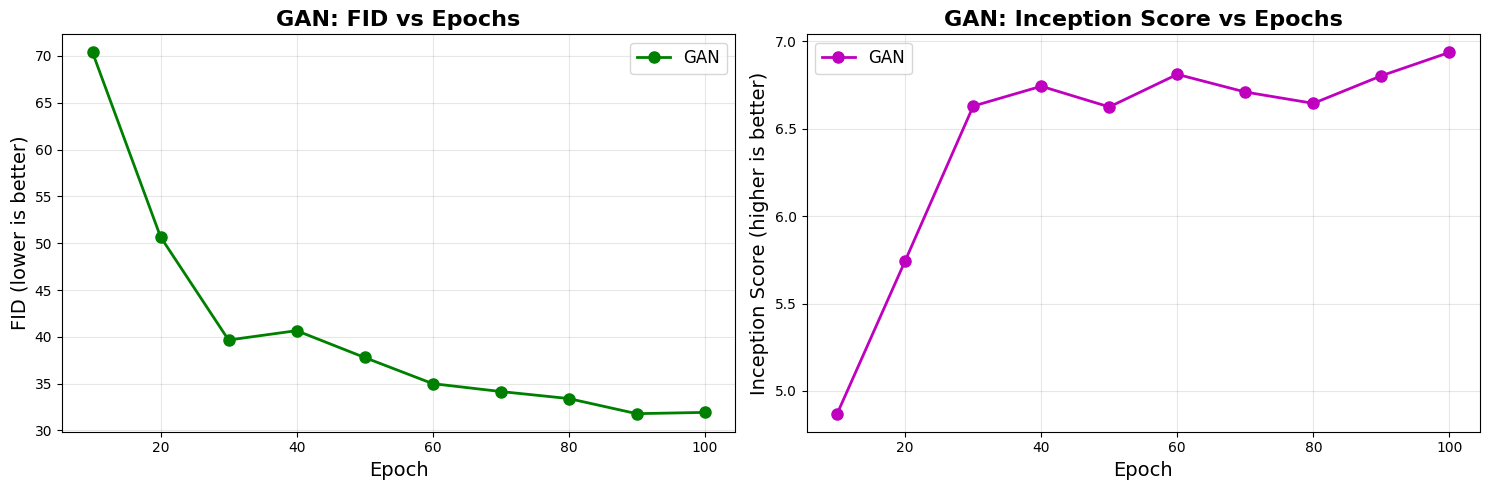

✅ Data saved to: /content/drive/MyDrive/model_evaluation_graphs/gan_metrics.csv

GAN SUMMARY
Best FID: 31.79 at epoch 90
Best IS: 6.94 at epoch 100
Final FID: 31.93 at epoch 100
Final IS: 6.94 at epoch 100

✅ GAN Evaluation complete!


In [ ]:
# ============================================================
# EVALUATE GAN CHECKPOINTS AND PLOT FID/IS vs EPOCHS
# ============================================================

import os
import glob
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torchvision.utils import save_image
import math

# Try to mount drive
try:
    from google.colab import drive
    if not os.path.exists('/content/drive/MyDrive'):
        drive.mount('/content/drive')
    print("✅ Drive mounted")
except Exception as e:
    print(f"⚠️ Drive mount failed or not in Colab: {e}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------------------------
# PATHS
# -------------------------

GAN_DIR = "/content/drive/MyDrive/gan_cifar10_runs"
GAN_CKPT_PATTERN = "dcgan_epoch_*.pth"

GRAPH_OUTPUT_DIR = "/content/drive/MyDrive/model_evaluation_graphs"
os.makedirs(GRAPH_OUTPUT_DIR, exist_ok=True)

print(f"Checkpoint directory: {GAN_DIR}")
print(f"Graphs will be saved to: {GRAPH_OUTPUT_DIR}")

if not os.path.exists(GAN_DIR):
    print(f"❌ ERROR: Directory does not exist: {GAN_DIR}")
else:
    print(f"✅ Checkpoint directory found")


# -------------------------
# GAN MODEL DEFINITIONS
# -------------------------

class Generator(nn.Module):
    def __init__(self, latent_dim=128, fm=128):
        super().__init__()
        self.net = nn.Sequential(
            # (N, latent_dim, 1, 1) -> (N, fm*8, 4, 4)
            nn.ConvTranspose2d(latent_dim, fm*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(fm*8), nn.ReLU(True),

            # 4->8
            nn.ConvTranspose2d(fm*8, fm*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(fm*4), nn.ReLU(True),

            # 8->16
            nn.ConvTranspose2d(fm*4, fm*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(fm*2), nn.ReLU(True),

            # 16->32
            nn.ConvTranspose2d(fm*2, fm, 4, 2, 1, bias=False),
            nn.BatchNorm2d(fm), nn.ReLU(True),

            # (N, fm, 32, 32) -> (N, 3, 32, 32)
            nn.ConvTranspose2d(fm, 3, 3, 1, 1, bias=False),
            nn.Tanh(),  # [-1,1]
        )

    def forward(self, z):
        return self.net(z)


def denorm(x):
    return (x.clamp(-1,1) + 1)/2


# -------------------------
# EVALUATION FUNCTIONS
# -------------------------

def load_generator_from_checkpoint(ckpt_path, latent_dim=128, gen_fm=128):
    """Load generator from checkpoint"""
    print(f"\nLoading generator from: {os.path.basename(ckpt_path)}")

    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    # Get hyperparameters from checkpoint if available
    latent_dim = ckpt.get('LATENT_DIM', latent_dim)
    gen_fm = ckpt.get('GEN_FM', gen_fm)

    # Create generator
    G = Generator(latent_dim, gen_fm).to(device)

    # Load state dict
    if 'G' in ckpt:
        G.load_state_dict(ckpt['G'])
    elif 'generator' in ckpt:
        G.load_state_dict(ckpt['generator'])
    else:
        G.load_state_dict(ckpt)

    G.eval()
    return G, latent_dim


def generate_samples_from_gan(ckpt_path, output_dir, num_samples=5000):
    """Generate samples from a GAN checkpoint"""
    print(f"\nGenerating samples from: {os.path.basename(ckpt_path)}")

    G, latent_dim = load_generator_from_checkpoint(ckpt_path)

    os.makedirs(output_dir, exist_ok=True)

    bs = 100
    saved = 0

    with torch.no_grad():
        pbar = tqdm(total=num_samples, desc="Generating")
        while saved < num_samples:
            cur = min(bs, num_samples - saved)

            # Generate random latent vectors
            z = torch.randn(cur, latent_dim, 1, 1, device=device)

            # Generate images
            fake_imgs = G(z)
            fake_imgs = denorm(fake_imgs).cpu()

            # Save images
            for i in range(cur):
                save_image(fake_imgs[i], os.path.join(output_dir, f"{saved + i:05d}.png"))

            saved += cur
            pbar.update(cur)
        pbar.close()

    del G
    torch.cuda.empty_cache()

    return output_dir


def calculate_metrics_for_samples(samples_dir):
    """Calculate FID and IS for generated samples"""
    print(f"Calculating metrics for: {samples_dir}")

    try:
        from torch_fidelity import calculate_metrics
    except:
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'torch-fidelity>=0.3.0'])
        from torch_fidelity import calculate_metrics

    orig_torch_load = torch.load
    def _compat_load(*args, **kwargs):
        kwargs.setdefault("weights_only", False)
        return orig_torch_load(*args, **kwargs)
    torch.load = _compat_load

    try:
        metrics_fid = calculate_metrics(
            input1=samples_dir,
            input2="cifar10-train",
            fid=True,
            kid=False,
            isc=False,
            cuda=(device == "cuda"),
            verbose=False,
        )

        metrics_is = calculate_metrics(
            input1=samples_dir,
            fid=False,
            kid=False,
            isc=True,
            cuda=(device == "cuda"),
            verbose=False,
        )
    finally:
        torch.load = orig_torch_load

    fid = metrics_fid.get("frechet_inception_distance", None)
    is_mean = (metrics_is.get("inception_score_mean") or
               metrics_is.get("isc_mean") or
               metrics_is.get("inception_score"))
    is_std = metrics_is.get("inception_score_std", metrics_is.get("isc_std", None))

    return fid, is_mean, is_std


def evaluate_all_checkpoints(model_dir, ckpt_pattern, temp_sample_dir, num_samples=5000,
                             select_epochs=None):
    """Evaluate all checkpoints in a directory"""

    ckpt_files = sorted(glob.glob(os.path.join(model_dir, ckpt_pattern)))

    if not ckpt_files:
        print(f"❌ No checkpoints found matching pattern: {ckpt_pattern} in {model_dir}")
        return None, None, None

    print(f"Found {len(ckpt_files)} checkpoints")

    epochs = []
    for f in ckpt_files:
        match = re.search(r'epoch[_-](\d+)', os.path.basename(f))
        if match:
            epochs.append(int(match.group(1)))

    if not epochs:
        print("❌ Could not extract epoch numbers from checkpoint filenames")
        return None, None, None

    sorted_pairs = sorted(zip(epochs, ckpt_files))
    epochs, ckpt_files = zip(*sorted_pairs)

    if select_epochs is not None:
        filtered_pairs = [(e, f) for e, f in zip(epochs, ckpt_files) if e in select_epochs]
        if filtered_pairs:
            epochs, ckpt_files = zip(*filtered_pairs)
            print(f"Evaluating {len(epochs)} selected checkpoints: {list(epochs)}")
        else:
            print(f"❌ No checkpoints found for selected epochs: {select_epochs}")
            return None, None, None

    fids = []
    is_means = []
    is_stds = []

    for epoch, ckpt_path in zip(epochs, ckpt_files):
        print(f"\n{'='*60}")
        print(f"Evaluating Epoch {epoch}")
        print(f"{'='*60}")

        try:
            sample_output_dir = os.path.join(temp_sample_dir, f"epoch_{epoch}")
            generate_samples_from_gan(ckpt_path, sample_output_dir, num_samples)

            fid, is_mean, is_std = calculate_metrics_for_samples(sample_output_dir)

            fids.append(fid)
            is_means.append(is_mean)
            is_stds.append(is_std if is_std is not None else 0)

            is_std_str = f"{is_std:.2f}" if is_std else "0.00"
            print(f"✅ Epoch {epoch}: FID={fid:.2f}, IS={is_mean:.2f}±{is_std_str}")

            import shutil
            shutil.rmtree(sample_output_dir)

        except Exception as e:
            print(f"❌ Error evaluating epoch {epoch}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return list(epochs), fids, is_means


# -------------------------
# MAIN EVALUATION
# -------------------------

print("\n" + "="*70)
print("EVALUATING GAN MODEL CHECKPOINTS")
print("="*70)

TEMP_SAMPLE_DIR = "/content/temp_eval_samples_gan"
os.makedirs(TEMP_SAMPLE_DIR, exist_ok=True)

# SELECT WHICH EPOCHS TO EVALUATE
select_epochs = list(range(10, 101, 10))  # [10, 20, 30, ..., 100]
print(f"Will evaluate epochs: {select_epochs}")

gan_epochs, gan_fids, gan_is = evaluate_all_checkpoints(
    GAN_DIR,
    GAN_CKPT_PATTERN,
    os.path.join(TEMP_SAMPLE_DIR, "gan"),
    num_samples=5000,
    select_epochs=select_epochs
)


# -------------------------
# PLOT RESULTS
# -------------------------

if gan_epochs is not None and len(gan_epochs) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(gan_epochs, gan_fids, 'g-o', linewidth=2, markersize=8, label='GAN')
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('FID (lower is better)', fontsize=14)
    ax1.set_title('GAN: FID vs Epochs', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    ax2.plot(gan_epochs, gan_is, 'm-o', linewidth=2, markersize=8, label='GAN')
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Inception Score (higher is better)', fontsize=14)
    ax2.set_title('GAN: Inception Score vs Epochs', fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(GRAPH_OUTPUT_DIR, 'gan_metrics_vs_epochs.png'), dpi=300, bbox_inches='tight')
    print(f"\n✅ Graph saved to: {GRAPH_OUTPUT_DIR}/gan_metrics_vs_epochs.png")
    plt.show()

    import pandas as pd
    df = pd.DataFrame({
        'Epoch': gan_epochs,
        'FID': gan_fids,
        'IS_mean': gan_is
    })
    df.to_csv(os.path.join(GRAPH_OUTPUT_DIR, 'gan_metrics.csv'), index=False)
    print(f"✅ Data saved to: {GRAPH_OUTPUT_DIR}/gan_metrics.csv")

    print("\n" + "="*60)
    print("GAN SUMMARY")
    print("="*60)
    best_fid_idx = np.argmin(gan_fids)
    best_is_idx = np.argmax(gan_is)
    print(f"Best FID: {gan_fids[best_fid_idx]:.2f} at epoch {gan_epochs[best_fid_idx]}")
    print(f"Best IS: {gan_is[best_is_idx]:.2f} at epoch {gan_epochs[best_is_idx]}")
    print(f"Final FID: {gan_fids[-1]:.2f} at epoch {gan_epochs[-1]}")
    print(f"Final IS: {gan_is[-1]:.2f} at epoch {gan_epochs[-1]}")
else:
    print("❌ No checkpoints were successfully evaluated")

print("\n✅ GAN Evaluation complete!")

✅ Drive mounted
Device: cuda
Checkpoint directory: /content/drive/MyDrive/vae_cifar10_runs
Graphs will be saved to: /content/drive/MyDrive/model_evaluation_graphs
✅ Checkpoint directory found

EVALUATING VAE MODEL CHECKPOINTS
Will evaluate epochs: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Found 100 checkpoints
Evaluating 10 selected checkpoints: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Evaluating Epoch 10

Generating samples from: vae_epoch_010.pth

Loading decoder from: vae_epoch_010.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_10
✅ Epoch 10: FID=343.44, IS=1.76±0.04

Evaluating Epoch 20

Generating samples from: vae_epoch_020.pth

Loading decoder from: vae_epoch_020.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_20
✅ Epoch 20: FID=314.53, IS=1.81±0.04

Evaluating Epoch 30

Generating samples from: vae_epoch_030.pth

Loading decoder from: vae_epoch_030.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_30
✅ Epoch 30: FID=310.91, IS=1.79±0.03

Evaluating Epoch 40

Generating samples from: vae_epoch_040.pth

Loading decoder from: vae_epoch_040.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_40
✅ Epoch 40: FID=286.39, IS=1.90±0.02

Evaluating Epoch 50

Generating samples from: vae_epoch_050.pth

Loading decoder from: vae_epoch_050.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_50
✅ Epoch 50: FID=279.12, IS=1.90±0.05

Evaluating Epoch 60

Generating samples from: vae_epoch_060.pth

Loading decoder from: vae_epoch_060.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_60
✅ Epoch 60: FID=266.80, IS=1.94±0.05

Evaluating Epoch 70

Generating samples from: vae_epoch_070.pth

Loading decoder from: vae_epoch_070.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_70
✅ Epoch 70: FID=264.61, IS=1.93±0.03

Evaluating Epoch 80

Generating samples from: vae_epoch_080.pth

Loading decoder from: vae_epoch_080.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_80
✅ Epoch 80: FID=257.43, IS=2.00±0.04

Evaluating Epoch 90

Generating samples from: vae_epoch_090.pth

Loading decoder from: vae_epoch_090.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_90
✅ Epoch 90: FID=249.27, IS=2.00±0.04

Evaluating Epoch 100

Generating samples from: vae_epoch_100.pth

Loading decoder from: vae_epoch_100.pth
Using z_dim from checkpoint: 256
✅ Successfully loaded decoder with 21 parameters


Generating:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating metrics for: /content/temp_eval_samples_vae/vae/epoch_100
✅ Epoch 100: FID=242.15, IS=2.06±0.03

✅ Graph saved to: /content/drive/MyDrive/model_evaluation_graphs/vae_metrics_vs_epochs.png


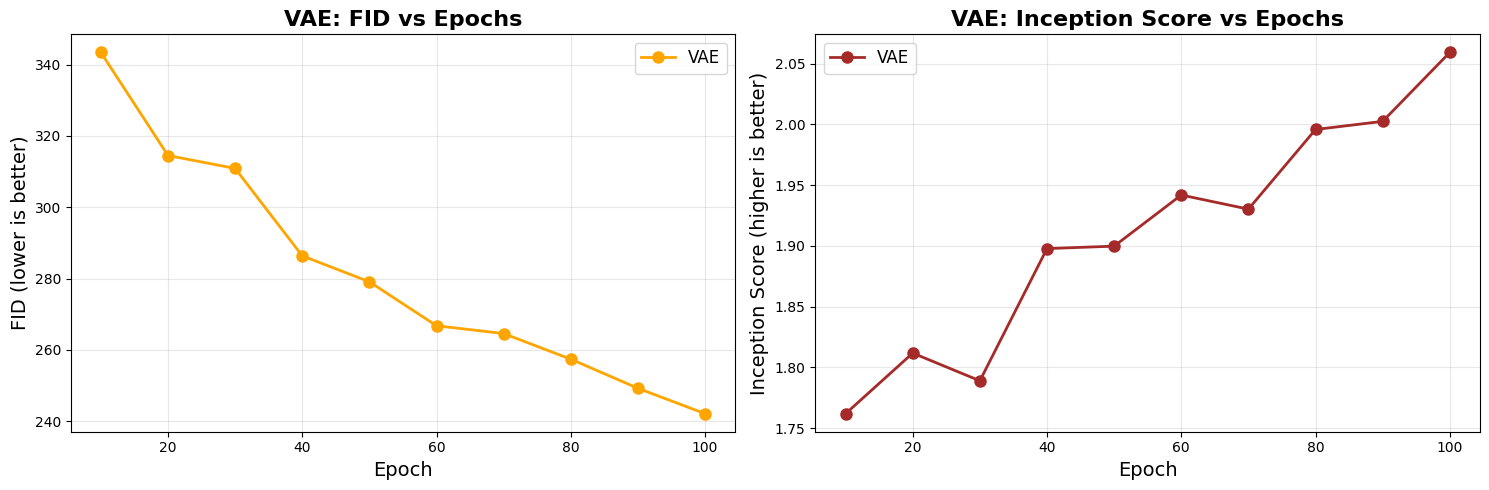

✅ Data saved to: /content/drive/MyDrive/model_evaluation_graphs/vae_metrics.csv

VAE SUMMARY
Best FID: 242.15 at epoch 100
Best IS: 2.06 at epoch 100
Final FID: 242.15 at epoch 100
Final IS: 2.06 at epoch 100

✅ VAE Evaluation complete!


In [ ]:
# ============================================================
# EVALUATE VAE CHECKPOINTS AND PLOT FID/IS vs EPOCHS (FIXED)
# ============================================================

import os
import glob
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torchvision.utils import save_image
import math

# Try to mount drive
try:
    from google.colab import drive
    if not os.path.exists('/content/drive/MyDrive'):
        drive.mount('/content/drive')
    print("✅ Drive mounted")
except Exception as e:
    print(f"⚠️ Drive mount failed or not in Colab: {e}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------------------------
# PATHS
# -------------------------

VAE_DIR = "/content/drive/MyDrive/vae_cifar10_runs"
VAE_CKPT_PATTERN = "vae_epoch_*.pth"

GRAPH_OUTPUT_DIR = "/content/drive/MyDrive/model_evaluation_graphs"
os.makedirs(GRAPH_OUTPUT_DIR, exist_ok=True)

print(f"Checkpoint directory: {VAE_DIR}")
print(f"Graphs will be saved to: {GRAPH_OUTPUT_DIR}")

if not os.path.exists(VAE_DIR):
    print(f"❌ ERROR: Directory does not exist: {VAE_DIR}")
else:
    print(f"✅ Checkpoint directory found")


# -------------------------
# VAE MODEL DEFINITIONS
# -------------------------

def denorm(x):
    return (x.clamp(-1,1) + 1)/2


class Decoder(nn.Module):
    """
    z (B,z) → FC 1024 → view (B,256,2,2) → 4× ConvTranspose2d → (B,3,32,32)
    """
    def __init__(self, z_dim=128):
        super().__init__()
        self.fc = nn.Linear(z_dim, 256*2*2)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1,bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False),  nn.BatchNorm2d(64),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64,32,4,2,1,bias=False),   nn.BatchNorm2d(32),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32,3,4,2,1,bias=False),
            nn.Tanh(),  # output in [-1,1]
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 256, 2, 2)
        return self.net(h)


# -------------------------
# EVALUATION FUNCTIONS
# -------------------------

def load_decoder_from_checkpoint(ckpt_path, z_dim=256):
    """Load decoder from VAE checkpoint"""
    print(f"\nLoading decoder from: {os.path.basename(ckpt_path)}")

    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    # Get z_dim from checkpoint if available
    if 'cfg' in ckpt:
        try:
            if isinstance(ckpt['cfg'], dict):
                z_dim = ckpt['cfg'].get('z_dim', 256)
            else:
                z_dim = getattr(ckpt['cfg'], 'z_dim', 256)
            print(f"Using z_dim from checkpoint: {z_dim}")
        except:
            z_dim = 256
            print(f"Using default z_dim: {z_dim}")

    # Create decoder
    decoder = Decoder(z_dim).to(device)

    # The checkpoint has 'model' which contains the full VAE
    if 'model' in ckpt:
        full_vae_state = ckpt['model']
        # Extract decoder weights (they start with 'dec.')
        decoder_state = {}
        for key, value in full_vae_state.items():
            if key.startswith('dec.'):
                new_key = key.replace('dec.', '')
                decoder_state[new_key] = value

        if decoder_state:
            decoder.load_state_dict(decoder_state)
            print(f"✅ Successfully loaded decoder with {len(decoder_state)} parameters")
        else:
            raise ValueError("No decoder weights found in checkpoint")
    else:
        raise ValueError(f"Unexpected checkpoint structure. Keys: {ckpt.keys()}")

    decoder.eval()
    return decoder, z_dim


def generate_samples_from_vae(ckpt_path, output_dir, num_samples=5000):
    """Generate samples from a VAE checkpoint"""
    print(f"\nGenerating samples from: {os.path.basename(ckpt_path)}")

    decoder, z_dim = load_decoder_from_checkpoint(ckpt_path)

    os.makedirs(output_dir, exist_ok=True)

    bs = 100
    saved = 0

    with torch.no_grad():
        pbar = tqdm(total=num_samples, desc="Generating")
        while saved < num_samples:
            cur = min(bs, num_samples - saved)

            # Sample from standard normal distribution
            z = torch.randn(cur, z_dim, device=device)

            # Generate images
            fake_imgs = decoder(z)
            fake_imgs = denorm(fake_imgs).cpu()

            # Save images
            for i in range(cur):
                save_image(fake_imgs[i], os.path.join(output_dir, f"{saved + i:05d}.png"))

            saved += cur
            pbar.update(cur)
        pbar.close()

    del decoder
    torch.cuda.empty_cache()

    return output_dir


def calculate_metrics_for_samples(samples_dir):
    """Calculate FID and IS for generated samples"""
    print(f"Calculating metrics for: {samples_dir}")

    try:
        from torch_fidelity import calculate_metrics
    except:
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'torch-fidelity>=0.3.0'])
        from torch_fidelity import calculate_metrics

    orig_torch_load = torch.load
    def _compat_load(*args, **kwargs):
        kwargs.setdefault("weights_only", False)
        return orig_torch_load(*args, **kwargs)
    torch.load = _compat_load

    try:
        metrics_fid = calculate_metrics(
            input1=samples_dir,
            input2="cifar10-train",
            fid=True,
            kid=False,
            isc=False,
            cuda=(device == "cuda"),
            verbose=False,
        )

        metrics_is = calculate_metrics(
            input1=samples_dir,
            fid=False,
            kid=False,
            isc=True,
            cuda=(device == "cuda"),
            verbose=False,
        )
    finally:
        torch.load = orig_torch_load

    fid = metrics_fid.get("frechet_inception_distance", None)
    is_mean = (metrics_is.get("inception_score_mean") or
               metrics_is.get("isc_mean") or
               metrics_is.get("inception_score"))
    is_std = metrics_is.get("inception_score_std", metrics_is.get("isc_std", None))

    return fid, is_mean, is_std


def evaluate_all_checkpoints(model_dir, ckpt_pattern, temp_sample_dir, num_samples=5000,
                             select_epochs=None):
    """Evaluate all checkpoints in a directory"""

    ckpt_files = sorted(glob.glob(os.path.join(model_dir, ckpt_pattern)))

    if not ckpt_files:
        print(f"❌ No checkpoints found matching pattern: {ckpt_pattern} in {model_dir}")
        return None, None, None

    print(f"Found {len(ckpt_files)} checkpoints")

    epochs = []
    for f in ckpt_files:
        match = re.search(r'epoch[_-](\d+)', os.path.basename(f))
        if match:
            epochs.append(int(match.group(1)))

    if not epochs:
        print("❌ Could not extract epoch numbers from checkpoint filenames")
        return None, None, None

    sorted_pairs = sorted(zip(epochs, ckpt_files))
    epochs, ckpt_files = zip(*sorted_pairs)

    if select_epochs is not None:
        filtered_pairs = [(e, f) for e, f in zip(epochs, ckpt_files) if e in select_epochs]
        if filtered_pairs:
            epochs, ckpt_files = zip(*filtered_pairs)
            print(f"Evaluating {len(epochs)} selected checkpoints: {list(epochs)}")
        else:
            print(f"❌ No checkpoints found for selected epochs: {select_epochs}")
            return None, None, None

    fids = []
    is_means = []
    is_stds = []

    for epoch, ckpt_path in zip(epochs, ckpt_files):
        print(f"\n{'='*60}")
        print(f"Evaluating Epoch {epoch}")
        print(f"{'='*60}")

        try:
            sample_output_dir = os.path.join(temp_sample_dir, f"epoch_{epoch}")
            generate_samples_from_vae(ckpt_path, sample_output_dir, num_samples)

            fid, is_mean, is_std = calculate_metrics_for_samples(sample_output_dir)

            fids.append(fid)
            is_means.append(is_mean)
            is_stds.append(is_std if is_std is not None else 0)

            is_std_str = f"{is_std:.2f}" if is_std else "0.00"
            print(f"✅ Epoch {epoch}: FID={fid:.2f}, IS={is_mean:.2f}±{is_std_str}")

            import shutil
            shutil.rmtree(sample_output_dir)

        except Exception as e:
            print(f"❌ Error evaluating epoch {epoch}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return list(epochs), fids, is_means


# -------------------------
# MAIN EVALUATION
# -------------------------

print("\n" + "="*70)
print("EVALUATING VAE MODEL CHECKPOINTS")
print("="*70)

TEMP_SAMPLE_DIR = "/content/temp_eval_samples_vae"
os.makedirs(TEMP_SAMPLE_DIR, exist_ok=True)

# SELECT WHICH EPOCHS TO EVALUATE
select_epochs = list(range(10, 101, 10))  # [10, 20, 30, ..., 100]
print(f"Will evaluate epochs: {select_epochs}")

vae_epochs, vae_fids, vae_is = evaluate_all_checkpoints(
    VAE_DIR,
    VAE_CKPT_PATTERN,
    os.path.join(TEMP_SAMPLE_DIR, "vae"),
    num_samples=5000,
    select_epochs=select_epochs
)


# -------------------------
# PLOT RESULTS
# -------------------------

if vae_epochs is not None and len(vae_epochs) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(vae_epochs, vae_fids, 'orange', marker='o', linewidth=2, markersize=8, label='VAE')
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('FID (lower is better)', fontsize=14)
    ax1.set_title('VAE: FID vs Epochs', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    ax2.plot(vae_epochs, vae_is, 'brown', marker='o', linewidth=2, markersize=8, label='VAE')
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Inception Score (higher is better)', fontsize=14)
    ax2.set_title('VAE: Inception Score vs Epochs', fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(GRAPH_OUTPUT_DIR, 'vae_metrics_vs_epochs.png'), dpi=300, bbox_inches='tight')
    print(f"\n✅ Graph saved to: {GRAPH_OUTPUT_DIR}/vae_metrics_vs_epochs.png")
    plt.show()

    import pandas as pd
    df = pd.DataFrame({
        'Epoch': vae_epochs,
        'FID': vae_fids,
        'IS_mean': vae_is
    })
    df.to_csv(os.path.join(GRAPH_OUTPUT_DIR, 'vae_metrics.csv'), index=False)
    print(f"✅ Data saved to: {GRAPH_OUTPUT_DIR}/vae_metrics.csv")

    print("\n" + "="*60)
    print("VAE SUMMARY")
    print("="*60)
    best_fid_idx = np.argmin(vae_fids)
    best_is_idx = np.argmax(vae_is)
    print(f"Best FID: {vae_fids[best_fid_idx]:.2f} at epoch {vae_epochs[best_fid_idx]}")
    print(f"Best IS: {vae_is[best_is_idx]:.2f} at epoch {vae_epochs[best_is_idx]}")
    print(f"Final FID: {vae_fids[-1]:.2f} at epoch {vae_epochs[-1]}")
    print(f"Final IS: {vae_is[-1]:.2f} at epoch {vae_epochs[-1]}")
else:
    print("❌ No checkpoints were successfully evaluated")

print("\n✅ VAE Evaluation complete!")